In [1]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
import time

In [2]:
tf.__version__

'2.3.0'

### 1)Linear Classifier for CIFAR10

In [3]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()
print('x_train: ', x_train.shape)
print('y_test: ',y_test.shape)
print('y_test[0]',y_test[0])

K = len(np.unique(y_train)) # Number of Classes
print('Number of classes: ',K)

x_train:  (50000, 32, 32, 3)
y_test:  (10000, 1)
y_test[0] [3]
Number of classes:  10


In [4]:
Ntr = x_train.shape[0]
Nte = x_test.shape[0]
Din = 3072 # CIFAR10, 32x32x3=3072
# Din = 784 # MINIST

# Normalize pixel values: numpy works in one datatype(weights,features):float, faster training,
x_train, x_test = x_train / 255.0, x_test / 255.0


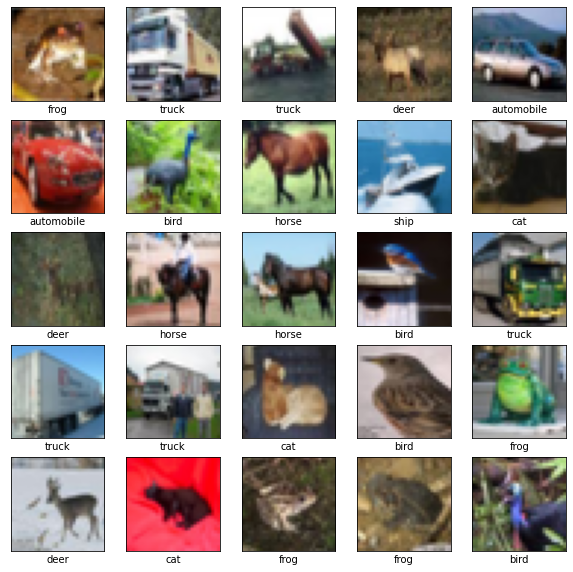

In [5]:
#verify data
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(x_train[i], cmap=plt.cm.binary)
    # The CIFAR labels happen to be arrays need the extra index
    plt.xlabel(class_names[y_train[i][0]])
plt.show()

In [6]:
#centering the data and making range similar in order to get stable gradients
mean_image = np.mean(x_train, axis=0)
x_train = x_train - mean_image
x_test = x_test - mean_image

#re-classify the y(label) sets as categorical: onehot encoding
y_train = tf.keras.utils.to_categorical(y_train, num_classes=K)
y_test = tf.keras.utils.to_categorical(y_test, num_classes=K)

#resize x set into a collection of rows, each row is an image
x_train = np.reshape(x_train,(Ntr,Din))
x_test = np.reshape(x_test,(Nte,Din))
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

print('y_train:', y_train.shape)
print('y_test:', y_test.shape)
print('x_train:', x_train.shape)
print('x_test:', x_test.shape)

y_train: (50000, 10)
y_test: (10000, 10)
x_train: (50000, 3072)
x_test: (10000, 3072)


In [7]:
#initialize the Weight matrix and bias 
std=1e-5
w1 = std*np.random.randn(Din, K)
b1 = np.zeros(K)
print("w1:", w1.shape)
print("b1:", b1.shape)

w1: (3072, 10)
b1: (10,)


In [8]:
#parameters
batch_size = Ntr    #set batchsize to entire trainingset size
iterations = 300
lr = 0.015         #learning rate
lr_decay= 0.9999   #learning rate decay
reg = 1e-7         #regularization parameter
loss_history = []
train_acc_history = []
val_acc_history = []

#fix seed for random number generator
seed = 0
rng = np.random.default_rng(seed=seed)

In [9]:
def accuracy(y_pred,y):
    predclass = np.argmax(y_pred,axis=1)
    realclass = np.argmax(y,axis=1)
    return ( np.sum(predclass==realclass)/realclass.size )

In [23]:
def reg_MSloss(y_pred,y,batchsize,reg,w1):
    return (1./batchsize)* np.square(y_pred-y).sum()  + reg*np.sum( [np.sum(w*w)for w in w1] )


In [24]:
def runlinearmodel(batchsize=batch_size,iterations=iterations,lr=lr,lr_decay=lr_decay,reg=reg):
    t0 = time.time()
    std=1e-5
    w1 = std*np.random.randn(Din, K)
    b1 = np.zeros(K)

    loss_history = []
    test_losshistory = []
    train_acc_history = []
    val_acc_history = []
    seed = 0
    rng = np.random.default_rng(seed=seed)

    for t in range(iterations+1):
        batch_indices = np.random.choice(Ntr,batch_size)
        rng.shuffle(batch_indices)
        x = x_train[batch_indices]
        y = y_train[batch_indices]

        # Forward pass
        y_pred = x.dot(w1) + b1
        testy = x_test.dot(w1) + b1

        train_loss = reg_MSloss(y_pred,y,batch_size,reg,[w1]) #regularized mean square loss
        test_loss = reg_MSloss(testy,y_test,10000,reg,[w1])
        loss_history.append(train_loss)
        test_losshistory.append(test_loss)

        train_acc= accuracy(y_pred,y)
        train_acc_history.append(train_acc)

        val_acc=accuracy(testy,y_test)
        val_acc_history.append(val_acc)
        

        if t%10 == 0:
            print('epoch %d/%d: MSloss= %f-- ,test loss= %f--,train accracy= %f--, test accracy= %f' % (t,iterations,train_loss,test_loss,train_acc,val_acc))
        
        dy_pred = (1./batch_size)*2.0*(y_pred-y)
        dw1 = x.T.dot(dy_pred) + reg*w1
        db1 = dy_pred.sum(axis=0)

        # Backward pass
        w1 -= lr*dw1
        b1 -= lr*db1
        lr *= lr_decay

    t1 = time.time()
    print('time taken = ',(t1-t0))

    return w1,loss_history,test_losshistory,train_acc_history,val_acc_history


In [25]:

w1,loss_history,test_losshistory,train_acc_history,val_acc_history = runlinearmodel()

epoch 0/300: MSloss= 0.999943-- ,test loss= 0.999945--,train accracy= 0.130920--, test accracy= 0.135700
epoch 10/300: MSloss= 0.874563-- ,test loss= 0.872906--,train accracy= 0.353080--, test accracy= 0.353000
epoch 20/300: MSloss= 0.839696-- ,test loss= 0.838699--,train accracy= 0.370160--, test accracy= 0.374300
epoch 30/300: MSloss= 0.821372-- ,test loss= 0.820346--,train accracy= 0.380640--, test accracy= 0.382300
epoch 40/300: MSloss= 0.809008-- ,test loss= 0.809888--,train accracy= 0.392460--, test accracy= 0.387800
epoch 50/300: MSloss= 0.803329-- ,test loss= 0.803802--,train accracy= 0.396700--, test accracy= 0.389500
epoch 60/300: MSloss= 0.798739-- ,test loss= 0.799847--,train accracy= 0.399780--, test accracy= 0.392700
epoch 70/300: MSloss= 0.795077-- ,test loss= 0.797427--,train accracy= 0.401140--, test accracy= 0.393800
epoch 80/300: MSloss= 0.795587-- ,test loss= 0.795577--,train accracy= 0.402820--, test accracy= 0.395900
epoch 90/300: MSloss= 0.792575-- ,test loss= 0.

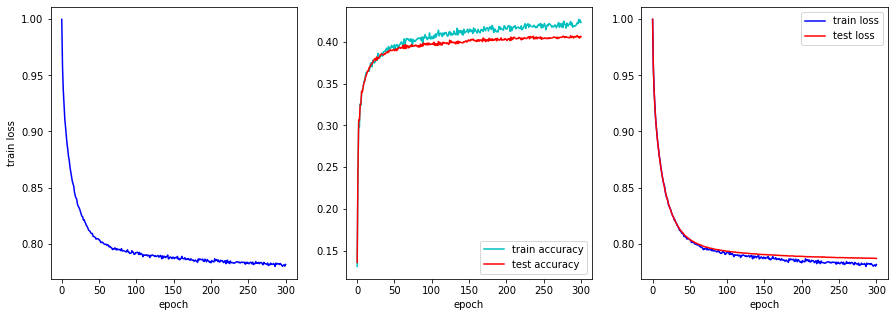

In [26]:
#display Train loss,train accuracy
fig,ax = plt.subplots(1,3,figsize=(15,5))
ax[0].plot(loss_history,'b')
ax[0].set_xlabel('epoch') 
ax[0].set_ylabel('train loss') 

ax[1].plot(train_acc_history,'c')
ax[1].plot(val_acc_history,'r')
ax[1].set_xlabel('epoch') 
ax[1].legend(['train accuracy','test accuracy'])

ax[2].plot(loss_history,'b')
ax[2].plot(test_losshistory,'r')
ax[2].set_xlabel('epoch') 
ax[2].legend(['train loss','test loss']);

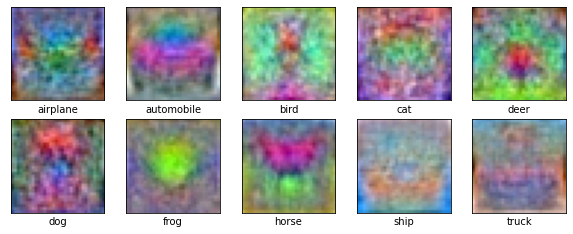

In [14]:
 # W is effectively 10 separate linear classifiers: one classifier per column of W 
 # Displaying w as images
plt.figure(figsize=(10,10))
for i in range(10):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    w = w1[:,i]
    wnorm = (w-min(w))/max(w) #+ mean_image.reshape(3072)
    wnorm = wnorm/max(wnorm)
    plt.imshow(wnorm.reshape((32,32,3)), cmap=plt.cm.binary)
    # The CIFAR labels happen to be arrays need the extra index
    plt.xlabel(class_names[i])
plt.show()


In [15]:
print(w1.shape)
w1_test = w1[:,1]
print(w1_test.shape)
#print(w1_test[:20])

(3072, 10)
(3072,)
[-1.08829525e-03 -2.03028576e-03 -1.88653903e-03  4.23025967e-05
 -9.93280607e-04 -9.59102197e-04  6.17367639e-04 -3.99358176e-04
 -3.71395747e-04 -7.12105417e-06 -1.29268207e-03 -1.16703059e-03
  6.87230077e-04 -4.94206519e-04 -8.09306133e-04 -1.75416186e-04
 -9.62277174e-04 -1.60653271e-03  2.42177322e-04 -9.84729745e-04]


[0.45393036 0.4067236  0.4139273  0.51058896 0.45869191 0.46040472
 0.53940768 0.48845564 0.48985695 0.50811215 0.44368775 0.44998463
 0.54290875 0.48370243 0.46791157 0.49967823 0.46024561 0.42795949
 0.52060545 0.45912042]


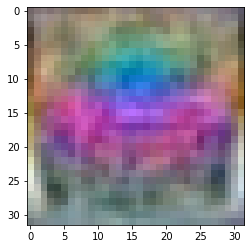

In [16]:
w1norm = (w1_test-min(w1_test))/max(w1_test)
w1norm = w1norm/max(w1norm)
#print(w1norm[:20])
plt.figure(figsize=(4,4))
plt.imshow(w1norm.reshape((32,32,3)) )
plt.show()

### 2) 2 Layer Fully connected NN
####   Hidden Layer activation - sigmoid

In [39]:
def run2LNN(batchsize=batch_size,iterations=iterations,lr=lr,lr_decay=lr_decay,reg=reg):
    t0 = time.time()
    std=1e-5
    H = 200
    w1 = std*np.random.randn(Din, H)
    b1 = np.zeros(H)
    w2 = std*np.random.randn(H,K)
    b2 = np.zeros(K)

    loss_history = []
    test_losshistory = []
    train_acc_history = []
    val_acc_history = []
    seed = 0
    rng = np.random.default_rng(seed=seed)

    for t in range(iterations+1):
        batch_indices = np.random.choice(Ntr,batch_size)
        rng.shuffle(batch_indices)
        x = x_train[batch_indices]
        y = y_train[batch_indices]

        # Forward pass
        z = x.dot(w1) + b1
        a = 1./(1 + np.exp(-z)) #sigmoid activation
        y_pred = a.dot(w2) + b2

        testz = x_test.dot(w1) + b1
        testa = 1./(1 + np.exp(-testz)) #sigmoid activation
        testy = testa.dot(w2) + b2

        train_loss = reg_MSloss(y_pred,y,batch_size,reg,[w1,w2]) #regularized mean square loss
        test_loss = reg_MSloss(testy,y_test,10000,reg,[w1,w2])
        loss_history.append(train_loss)
        test_losshistory.append(test_loss)

        train_acc= accuracy(y_pred,y)
        train_acc_history.append(train_acc)

        val_acc=accuracy(testy,y_test)
        val_acc_history.append(val_acc)
        

        if t%10 == 0:
            print('epoch %d/%d: MSloss= %f-- ,test loss= %f--,train accracy= %f--, test accracy= %f' % (t,iterations,train_loss,test_loss,train_acc,val_acc))
        
        dy_pred = (1./batch_size)*2.0*(y_pred-y)
        dw2 = a.T.dot(dy_pred) + reg*w2
        db2 = dy_pred.sum(axis=0)
        
        da = dy_pred.dot(w2.T)
        dz = a*(1-a)*da
        dw1 = x.T.dot(dz) + reg*w1
        db1 = dz.sum(axis=0)


        # Backward pass
        w1 -= lr*dw1
        b1 -= lr*db1
        w2 -= lr*dw2
        b2 -= lr*db2

        lr *= lr_decay

    t1 = time.time()
    print('time taken = ',(t1-t0))

    return loss_history,test_losshistory,train_acc_history,val_acc_history

In [44]:
loss_history,test_losshistory,train_acc_history,val_acc_history = run2LNN(lr=0.020,lr_decay=0.7,reg=0)

epoch 0/300: MSloss= 1.000069-- ,test loss= 1.000069--,train accracy= 0.099860--, test accracy= 0.100000
epoch 10/300: MSloss= 0.900000-- ,test loss= 0.900003--,train accracy= 0.101020--, test accracy= 0.100000
epoch 20/300: MSloss= 0.900004-- ,test loss= 0.900003--,train accracy= 0.100220--, test accracy= 0.100000
epoch 30/300: MSloss= 0.899995-- ,test loss= 0.900003--,train accracy= 0.101700--, test accracy= 0.100000
epoch 40/300: MSloss= 0.900003-- ,test loss= 0.900003--,train accracy= 0.098660--, test accracy= 0.100000
epoch 50/300: MSloss= 0.900013-- ,test loss= 0.900003--,train accracy= 0.096120--, test accracy= 0.100000
epoch 60/300: MSloss= 0.899996-- ,test loss= 0.900003--,train accracy= 0.102000--, test accracy= 0.100000
epoch 70/300: MSloss= 0.900001-- ,test loss= 0.900003--,train accracy= 0.100340--, test accracy= 0.100000
epoch 80/300: MSloss= 0.900011-- ,test loss= 0.900003--,train accracy= 0.096080--, test accracy= 0.100000
epoch 90/300: MSloss= 0.900003-- ,test loss= 0.

KeyboardInterrupt: 